## Hyper Parameters

In [1]:
### torch_geometric 설치를 위한 cell. 없이도 torch geometric이 잘 된다면 삭제해도 무방하다고 생각.

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import torch.nn.modules.loss
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import argparse
import time
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='gcn_ae', help="models used")
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--hidden', type=int, default=32, help='Number of units in hidden layer 1.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--dropout', type=float, default=0., help='Dropout rate (1 - keep probability).')
parser.add_argument('--dataset', type=str, default='cora', help='type of dataset.')
parser.add_argument('--feat-dim', type=int, default=10000, help='Maximum Dimension of Node Features')
parser.add_argument('--max-num-nodes', type=int, default=100000, help='Maximum Dimension of Node Features')
parser.add_argument("-f")

args = parser.parse_args()

## Data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [16]:
dataset = []
for data_name in ['cora','citeseer','pubmed']:
  args.dataset = data_name
  data = Planetoid(root=f'/tmp/{args.dataset}', name=args.dataset)
  data = data[0].to(device)
  dataset.append(data)

print(dataset)

[Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]), Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327]), Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])]


In [107]:
train_mask = [i for i in range(0,1)]      ### train = [cora]
val_mask = [i for i in range(1,2)]        ### valid = [citeseer]
test_mask = [i for i in range(2,3)]       ### test = [pubmed]

In [108]:
p1d = (0, args.feat_dim)
def zero_padding_features(input):
  p1d = (0,args.feat_dim - input.shape[1])
  return F.pad(input,p1d,"constant",0)

train_dataset = [(zero_padding_features(dataset[i].x), dataset[i].edge_index) for i in train_mask]
valid_dataset = [(zero_padding_features(dataset[i].x), dataset[i].edge_index) for i in val_mask]
test_dataset = [(zero_padding_features(dataset[i].x), dataset[i].edge_index) for i in test_mask]

dataloaders = {}
dataloaders['train'] = train_dataset
dataloaders['valid'] = valid_dataset
dataloaders['test'] = test_dataset

## Model 

In [109]:
class GCNModelAE(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim, dropout):
        super(GCNModelAE, self).__init__()
        self.gc = GCNConv(input_feat_dim, hidden_dim)
        self.dropout = dropout

    def forward(self, x, adj):
        output = self.gc(x, adj)
        output = F.leaky_relu(output, 0.2)
        output = F.dropout(output, p = self.dropout, training=self.training)
        output = F.sigmoid(torch.mm(output, output.t()))
        return output

## Loss func & Optimizer

In [110]:
model = GCNModelAE(args.feat_dim, args.hidden, args.dropout).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= args.lr)

## Train

In [111]:
def train_model(model,dataloaders,loss_func,optimizer):
  train_loss_history = []
  valid_loss_history = []
  for epoch in range(args.epochs):
    print('Epoch {}/{}'.format(epoch, args.epochs - 1))
    print('-' * 10)
    for phase in ['train','valid']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      cur_loss = 0.0

      for node_features, edge_index in dataloaders[phase]:
        node_features.to(device)
        edge_index.to(device)
      
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          output = model(node_features,edge_index)
          loss = loss_func(output, to_dense_adj(edge_index))  

          if phase == 'train':
            loss.backward()
            optimizer.step()

        cur_loss += loss.item()
      
      if phase == 'train':
        train_loss_history.append(cur_loss / len(dataloaders["train"]))
      if phase == 'valid':
        valid_loss_history.append(cur_loss / len(dataloaders["valid"]))

      print('{} Loss: {:.4f}'.format(phase, cur_loss))
    print()
  
  return model, train_loss_history, valid_loss_history

In [112]:
model, train_loss_history, valid_loss_history = train_model(model,dataloaders,loss_func,optimizer)

Epoch 0/199
----------
train Loss: 0.2525
valid Loss: 0.2502

Epoch 1/199
----------
train Loss: 0.2827
valid Loss: 0.2501

Epoch 2/199
----------
train Loss: 0.2707
valid Loss: 0.2501

Epoch 3/199
----------
train Loss: 0.2658


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 3327, 3327])) that is different to the input size (torch.Size([3327, 3327])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 19717, 19717])) that is different to the input size (torch.Size([19717, 19717])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


valid Loss: 0.2502

Epoch 4/199
----------
train Loss: 0.2719
valid Loss: 0.2501

Epoch 5/199
----------
train Loss: 0.2656
valid Loss: 0.2501

Epoch 6/199
----------
train Loss: 0.2619
valid Loss: 0.2501

Epoch 7/199
----------
train Loss: 0.2642
valid Loss: 0.2501

Epoch 8/199
----------
train Loss: 0.2710
valid Loss: 0.2502

Epoch 9/199
----------
train Loss: 0.2754
valid Loss: 0.2502

Epoch 10/199
----------
train Loss: 0.2765
valid Loss: 0.2502

Epoch 11/199
----------
train Loss: 0.2747
valid Loss: 0.2501

Epoch 12/199
----------
train Loss: 0.2703
valid Loss: 0.2501

Epoch 13/199
----------
train Loss: 0.2650
valid Loss: 0.2501

Epoch 14/199
----------
train Loss: 0.2614
valid Loss: 0.2500

Epoch 15/199
----------
train Loss: 0.2564
valid Loss: 0.2500

Epoch 16/199
----------
train Loss: 0.2552
valid Loss: 0.2500

Epoch 17/199
----------
train Loss: 0.2536
valid Loss: 0.2500

Epoch 18/199
----------
train Loss: 0.2543
valid Loss: 0.2500

Epoch 19/199
----------
train Loss: 0.257

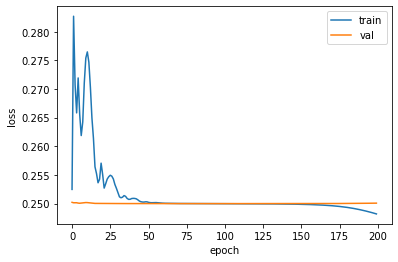

In [113]:
x_axis = [i for i in range(args.epochs)]
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Test

In [114]:
with torch.no_grad():
    cur_loss = 0.0
    for node_features, edge_index in dataloaders["test"]:
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)

        outputs = model(node_features,edge_index)
        test_loss = loss_func(outputs, to_dense_adj(edge_index))
        
        cur_loss += test_loss.item()

    test_loss = cur_loss / len(dataloaders["test"])
    print(test_loss)     

0.2519385814666748


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 2708, 2708])) that is different to the input size (torch.Size([2708, 2708])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
